<a href="https://colab.research.google.com/github/BryanMed/Sequences-Time-Series-and-Prediction/blob/master/NacimientoMujeres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nacimiento de mujeres
Vamos a trabajar con un dataset de nacimiento de mujeres del año 1959 donde se registraron los nacimientos de mujeres diariamente a lo largo del año. Utilizando una multilayer perceptron.

In [0]:
! pip install tf.nightly-2.0-preview

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.0.0-dev20191002


Vamos a cargar el dataset, el cual contiene los nacimientos de mujeres diarios desde el 1° de enero de 1959 hasta el 31 de diciembre de ese mismo año.

In [5]:
nacimiento_mujeres = pd.read_csv('https://raw.githubusercontent.com/BryanMed/Sequences-Time-Series-and-Prediction/master/datasets/nacimiento_mujeres.csv')
nacimiento_mujeres

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [6]:
header = nacimiento_mujeres.columns
print(header)

Index(['Date', 'Births'], dtype='object')


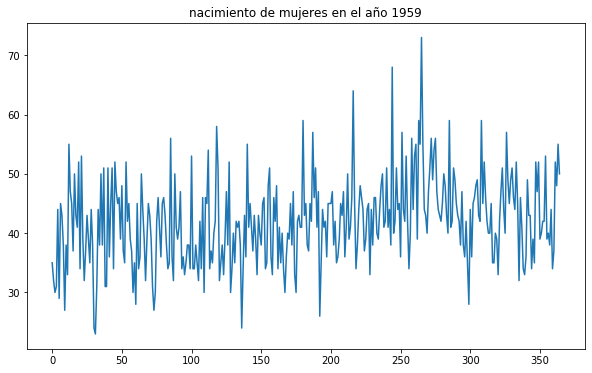

In [8]:
time = np.array(nacimiento_mujeres.get('Date'))
series = np.array(nacimiento_mujeres.get('Births'))

plt.figure(figsize=(10, 6))
plt.title('nacimiento de mujeres en el año 1959')
plt.plot(series)
plt.show()


Ahora dividiremos nuestros datos en **datos de entrenamiento** y **datos de validación**

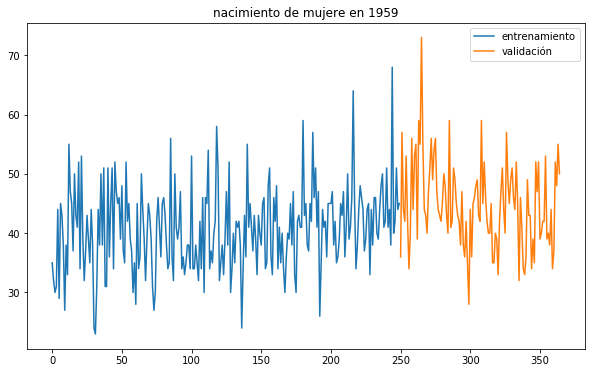

In [9]:
#creo el array dias dado que el formato de las fechas se me hace incómodo de trabajar
#así que haré una variable correspondiente a los 365 dias
dias = np.array(range(len(series+1)))

split_time = 250
time_train = time[:split_time]
dias_train = dias[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
dias_valid = dias[split_time:]
x_valid = series[split_time:]


plt.figure(figsize=(10 , 6))
plt.plot(dias_train, x_train)
plt.plot(dias_valid, x_valid)
plt.legend(('entrenamiento', 'validación'))
plt.title('nacimiento de mujere en 1959')
plt.show()


Vamos a poner nuestros en un formato adecuado

Vamos a transformar la serie en parámetros y labels (etiquetas). Con lo que tendremos una ventana de valores sucesivos, y el último valor de la ventana será el valor a predecir.


In [0]:
window_size = 30
batch_size = 15
shuffle_buffer = 365

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(2).prefetch(1)

In [0]:
for x, y in dataset:
  print('parametros:', x.numpy(), 'label:', y.numpy())

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset, epochs=200, verbose=0)

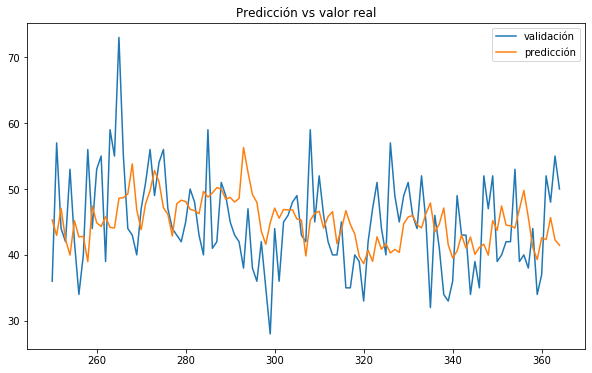

In [31]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]



plt.figure(figsize=(10, 6))
plt.plot(dias_valid, x_valid)
plt.plot(dias_valid, results)
plt.legend(('validación', 'predicción'))
plt.title('Predicción vs valor real')
plt.show()

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.224633